In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Задание 1:

In [5]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "..\data/data3",
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(400,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


In [6]:
train_ds.class_names

['cats', 'dogs']

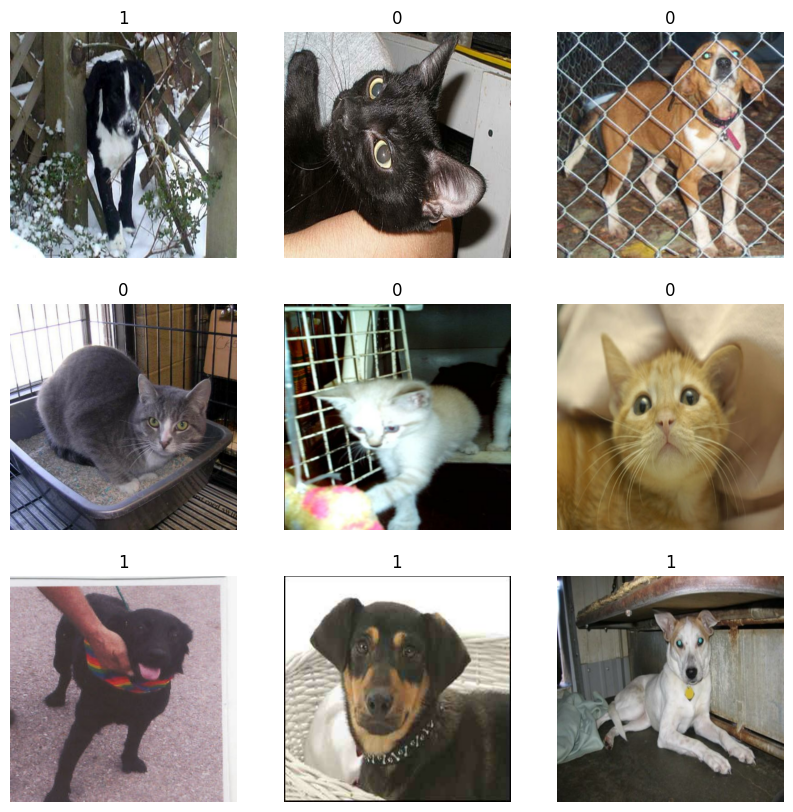

In [7]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.5),
        tf.keras.layers.RandomContrast(factor=1),
    ]
)

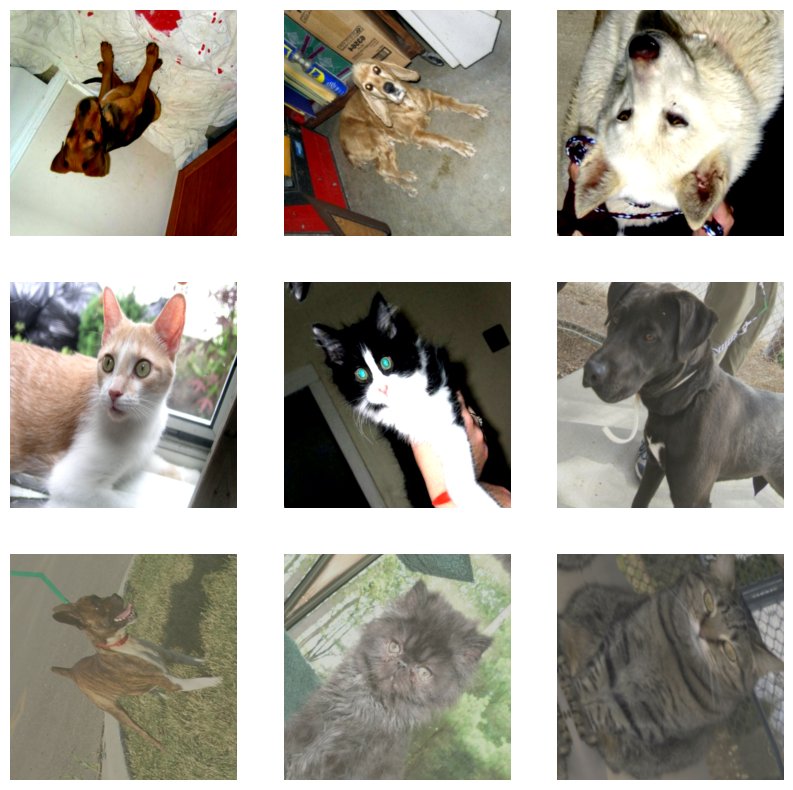

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

In [11]:
inputs = tf.keras.Input(shape=(400, 400, 3))
# преобразуем значения пикселей из [0, 255] к [0, 1]
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
# первый сверточный слой
# padding same заполняет матрицу по контуру нулями, применяем ядро(оно почти везде 3х3) и поэлементро суммируем полученную матрицу.
#strides - длина шага свёртки.
x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same")(x)
# первый пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# второй сверточный слой
x = tf.keras.layers.Conv2D(128, 4, strides=2, padding="same")(x)
# второй пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# выпрямляем многомерный массив
x = tf.keras.layers.Flatten()(x)
# полносвязный слой с 64 нейронами
x = tf.keras.layers.Dense(64, activation="relu")(x)
# выходной слой с функцией sofrmax
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 128)       0         
 g2D)                                                        

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [11]:
model.fit(train_ds,
          epochs=5)

Epoch 1/5
50/50 [==============================] - 40s 767ms/step - loss: 1.3545 - accuracy: 0.5188
Epoch 2/5
50/50 [==============================] - 38s 760ms/step - loss: 0.7110 - accuracy: 0.5469
Epoch 3/5
50/50 [==============================] - 38s 759ms/step - loss: 0.6918 - accuracy: 0.5344
Epoch 4/5
50/50 [==============================] - 39s 775ms/step - loss: 0.6710 - accuracy: 0.5744
Epoch 5/5
50/50 [==============================] - 40s 787ms/step - loss: 0.6721 - accuracy: 0.5756


In [12]:
test_loss, test_accuracy = model.evaluate(train_ds)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

50/50 [==============================] - 29s 573ms/step - loss: 0.6894 - accuracy: 0.5913
Test loss: 0.6894
Test accuracy: 0.5913


## Реализация свёрточного слоя


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [18]:
import numpy as np

class MLP:
    def __init__(self, layer_sizes, activation_functions):
        self.num_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.activation_functions = activation_functions
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i-1]) for i in range(1, self.num_layers)]
        self.biases = [np.random.randn(layer_sizes[i], 1) for i in range(1, self.num_layers)]

    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def _sigmoid_derivative(self, x):
        return self._sigmoid(x) * (1 - self._sigmoid(x))

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def _feed_forward(self, x):
        activations = [x]
        zs = []
        for i in range(self.num_layers - 1):
            weight = self.weights[i]
            bias = self.biases[i]
            activation_fn = self.activation_functions[i]
            z = np.dot(weight, activations[-1]) + bias
            zs.append(z)
            if activation_fn == 'sigmoid':
                a = self._sigmoid(z)
            elif activation_fn == 'tanh':
                a = self._tanh(z)
            elif activation_fn == 'relu':
                a = self._relu(z)
            activations.append(a)
        return activations, zs

    def _backpropagate(self, x, y):
        delta_weights = [np.zeros(weight.shape) for weight in self.weights]
        delta_biases = [np.zeros(bias.shape) for bias in self.biases]
        activations, zs = self._feed_forward(x)
        delta = (activations[-1] - y)  # derivative of the loss function
        for i in range(self.num_layers - 2, -1, -1):
            z = zs[i]
            activation_fn = self.activation_functions[i]
            if activation_fn == 'sigmoid':
                derivative = self._sigmoid_derivative(z)
            elif activation_fn == 'tanh':
                derivative = self._tanh_derivative(z)
            elif activation_fn == 'relu':
                derivative = self._relu_derivative(z)
            delta_weights[i] = np.dot(delta, activations[i].T)
            delta_biases[i] = delta
            delta = np.dot(self.weights[i].T, delta) * derivative
        return delta_weights, delta_biases
        
    def update_parameters(self, delta_weights, delta_biases, learning_rate):
        self.weights = [w - learning_rate * dw for w, dw in zip(self.weights, delta_weights)]
        self.biases = [b - learning_rate * db for b, db in zip(self.biases, delta_biases)]

    def train(self, X_train, y_train, learning_rate, num_epochs):
        for epoch in range(num_epochs):
            for x, y in zip(X_train, y_train):
                x = np.array(x, ndmin=2).T
                y = np.array(y, ndmin=2).T
                delta_weights, delta_biases = self._backpropagate(x, y)
                self.weights = [weight - learning_rate * d_weight for weight, d_weight in zip(self.weights, delta_weights)]
                self.biases = [bias - learning_rate * d_bias for bias, d_bias in zip(self.biases, delta_biases)]

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            x = np.array(x, ndmin=2).T
            activations, _ = self._feed_forward(x)
            predictions.append(activations[-1])
        return predictions

In [19]:
class ConvLayer:
    def __init__(self, num_filters, kernel_size):
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        # Инициализация фильтров с небольшими случайными значениями
        self.filters = np.random.randn(num_filters, kernel_size, kernel_size) / (kernel_size * kernel_size)
    
    def _convolve(self, input, filter):
        input_size = input.shape[1]
        output_size = input_size - self.kernel_size + 1
        output = np.zeros((output_size, output_size))
        for x in range(output_size):
            for y in range(output_size):
                patch = input[:, x:x+self.kernel_size, y:y+self.kernel_size]
                output[x, y] = np.sum(patch * filter)
        return output
    
    def forward_pass(self, input):
        self.last_input = input # Сохраняем для обратного прохода
        num_examples, _, _ = input.shape
        output_size = input.shape[1] - self.kernel_size + 1
        self.feature_maps = np.zeros((num_examples, self.num_filters, output_size, output_size))
        for i in range(self.num_filters):
            for j in range(num_examples):
                self.feature_maps[j, i] = self._convolve(input[j], self.filters[i])
        return self.feature_maps
    
    def backward_pass(self, d_L_d_out, learning_rate):
        num_examples, _, _, _ = d_L_d_out.shape
        # Градиенты фильтров
        d_L_d_filters = np.zeros(self.filters.shape)
        for i in range(num_examples):
            for f in range(self.num_filters):
                for x in range(self.last_input.shape[1] - self.kernel_size + 1):
                    for y in range(self.input.shape[2] - self.kernel_size + 1):
                        patch = self.last_input[i, :, x:x+self.kernel_size, y:y+self.kernel_size]
                        d_L_d_filters[f] += d_L_d_out[i, f, x, y] * patch
        
        return d_L_d_filters # Возвращаем градиенты для дальнейших слоев
    def update_filters(self, d_L_d_filters, learning_rate):
        self.filters -= learning_rate * d_L_d_filters

In [20]:
class CNN:
    def __init__(self, conv_num_filters, conv_kernel_size, pool_size, mlp_layer_sizes, activation_functions):
        self.conv_layers = [ConvLayer(conv_num_filters, conv_kernel_size)]
        self.fc_layers = MLP(mlp_layer_sizes, activation_functions)

    def forward_pass(self, input):
        conv_output = self.conv_layers[0].forward_pass(input)
        flattened = conv_output.reshape(conv_output.shape[0], -1)
        fc_output = self.fc_layers._feed_forward(flattened)
        return fc_output

    def train(self, X_train, y_train, learning_rate, epochs):
        for epoch in range(epochs):
            for x_batch, y_batch in zip(X_train, y_train):
                output = self.forward_pass(x_batch)
                
                delta_weights, delta_biases = self.fc_layers._backpropagate(output[-1], y_batch)
                self.fc_layers.update_parameters(delta_weights, delta_biases, learning_rate)
                
                d_L_d_out = delta_weights[0]
                
                d_L_d_filters = self.conv_layers[0].backward_pass(d_L_d_out, learning_rate)
                self.conv_layers[0].update_filters(d_L_d_filters, learning_rate)

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            x = x[np.newaxis, :] 
            output = self.forward_pass(x)
            predictions.append(output)
        return predictions

In [21]:
conv_num_filters = 10
conv_kernel_size = 3
mlp_layer_sizes = [512, 256, 1]  
activation_functions = ['relu', 'relu', 'sigmoid'] 

cnn = CNN(conv_num_filters, conv_kernel_size, 2, mlp_layer_sizes, activation_functions)

In [3]:
class CNN:   
    def __init__(self, input_size ,layersCount ,LayersInfo , learning_rate, kernel_size, strides):
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.strides = strides
        self.hidden_layers = layersCount
        self.neurons = LayersInfo[0]
        print(self.neurons)
        self.activations = list(map(lambda x: self.addActivations[x], LayersInfo[1]))
        self.derivatives = list(map(lambda x: self.addDerivatives[x], LayersInfo[1]))
        self.learning_rate = learning_rate
        self.weights = []
        self.bias = []
        self.loss_arr = [] 

    def _FindWeightsAndBias(self, input, index):
        self.weights.append(np.random.rand(input, self.neurons[index])*0.005)
        self.bias.append(np.random.rand(1, self.neurons[index])*0.005)

    def _FindKernel(self):
        return np.random.rand(self.kernel_size, self.kernel_size)

    addActivations = {'sigmoid': lambda x: math.round(1 / (1 + np.exp(-x))),
                     'relu': lambda x: np.maximum(0, x),
                     'tanh': lambda x: np.tanh(x),
                     'linear': lambda x: x}
    def SoftMax(self, x):
        tmp = np.exp(x)
        output = tmp / np.sum(x)
        return output
    
    addDerivatives = {'sigmoid': lambda x: math.round(np.exp(-x) / ((1 + np.exp(-x))**2)),
                     'relu': lambda x: np.where(x > 0, 1, 0),
                     'tanh': lambda x: 1 - np.tanh(x)**2,
                     'linear': lambda x: 1}

    def MSE(self, y_test, y_pred):
        f = lambda x,y: pow(x-y, 2) 
        return np.sum(list(map(f, y_test, y_pred)))/len(y_test)

    def _conv(self, X):
        strange_maxpooled_X = {np.zeros(self.input_size[1]), np.zeros(self.input_size[2])}
        for i in range(self.input_size[2]):
            for j in range(self.input_size[1]):
                max = X[0][j][i]
                for k in range(self.input_size[0]):
                    if max<X[k][j][i]:
                        max = X[k][j][i]
                strange_maxpooled_X[j][i] = max 
        

    
    def _start(self, X, y):
        y = self.y_data
        self.input = []
        self.weights = []
        self.bias = []
        self.layers = []
        self.input.append(X)
        for i in range(self.hidden_layers):
            print(self.input[-1].shape)
            self._FindWeightsAndBias(len(self.input[-1].T), i)

            print(self.weights[-1].shape)
            print(self.bias[-1].shape)
            layer = self.input[-1].dot(self.weights[-1]) + self.bias[-1]

            print(layer.shape, end = '\n\n')
            self.layers.append(layer)
            dense = self.activations[i](layer)
            self.input.append(dense)

        print(self.MSE(y, self.input[-1]))
        self.loss_arr.append(self.MSE(y, self.input[-1]))

        return self.input[-1]

    def _forward(self, X, y):
        y = self.y_data
        self.input = []
        self.layers = []
        self.input.append(X)
        for i in range(self.hidden_layers):
            layer = self.input[i].dot(self.weights[i]) + self.bias[i]
            self.layers.append(layer)
            dense = self.activations[i](layer)
            self.input.append(dense)

        print(self.MSE(y, self.input[-1]))
        self.loss_arr.append(self.MSE(y, self.input[-1]))
        r = lambda x: np.array(map(round, x))
        self.input[-1]=np.array(r(v) for v in self.input[-1])
        return self.input[-1]

    
    def _backward(self, X, y):
        delta_t = (self.input[-1] - y[:, np.newaxis])*np.array(self.derivatives[-1](self.layers[-1]))
        for i in range(1,len(self.weights)-1):
            self.weights[-i]-=self.learning_rate*(self.layers[-i-1].T.dot(delta_t))/len(y)
            self.bias[-i]-=np.sum(self.weights[-i])/len(y)
            delta_t = self.derivatives[-i-1](self.layers[-i-1])*(delta_t.dot(self.weights[-i].T))
            
    def train(self, X, y, epochs):
        self.y_data = y
        transformed_x = self._conv(X)
        output = self._start(transformed_x,y)
        for epoch in range(epochs):
            self._backward(transformed_x, y)
            transformed_x = self._conv(X)
            output = self._forward(transformed_x,y)
        np.argmaxself.SoftMax(x) for x in output]
        plt.plot(self.loss_arr)
        plt.show()
        

    def predict(self, X):
        return [np.argmax(self.SoftMax(x)) for x in self._forward(X, [])]


SyntaxError: invalid syntax (2414022423.py, line 111)

## Задание 2:

In [15]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    '..\data/data4',
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(224,224), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 162 files belonging to 3 classes.
Using 130 files for training.
Using 32 files for validation.


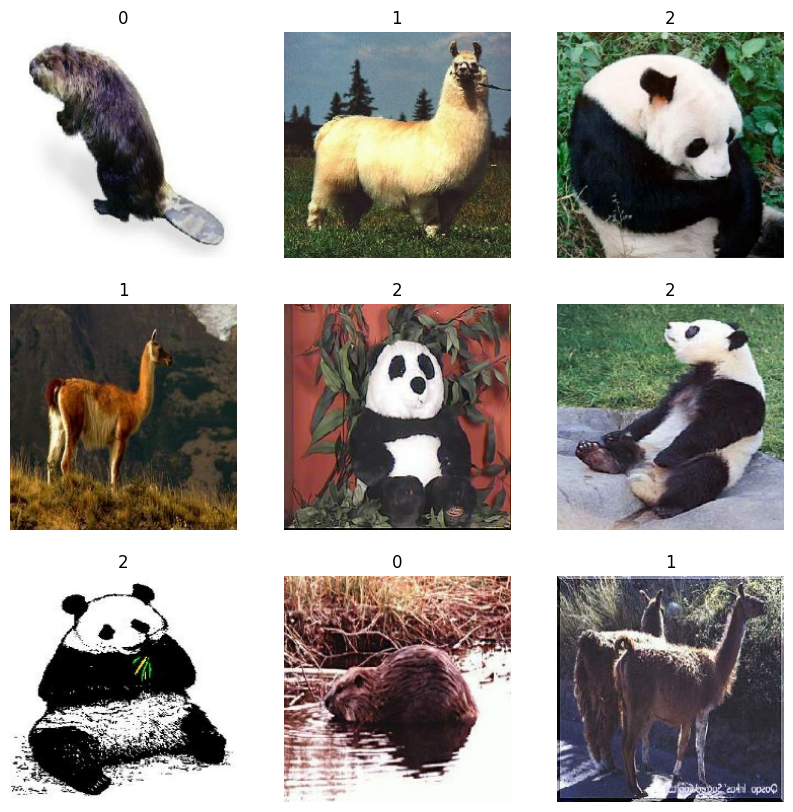

In [16]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [17]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.5),
        tf.keras.layers.RandomContrast(factor=1),
    ]
)

In [18]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

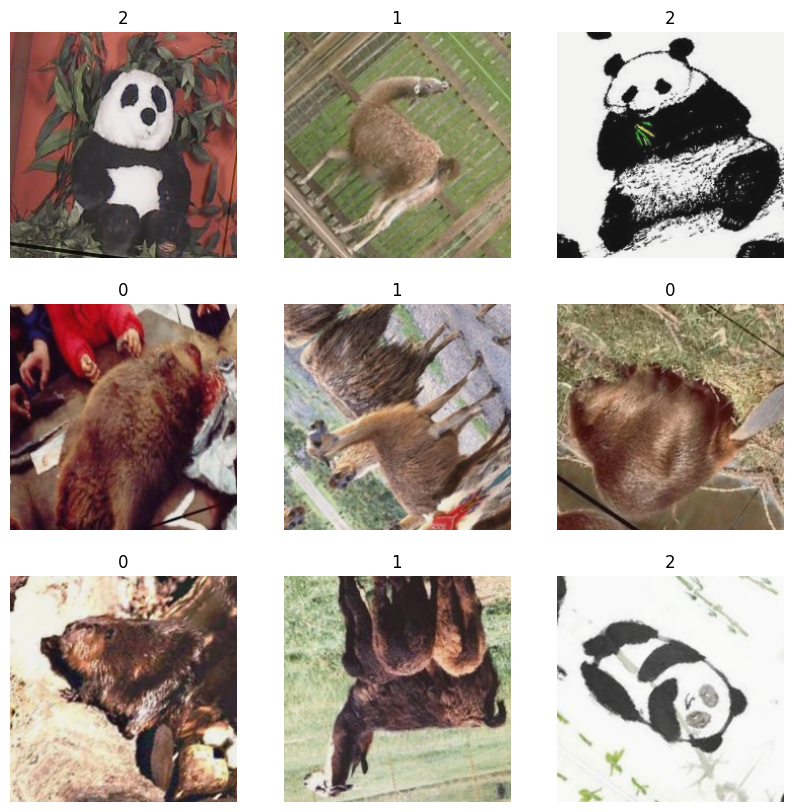

In [19]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [20]:
from tensorflow.keras.applications import InceptionV3, VGG19

vgg = VGG19(include_top = True, weights='imagenet')

In [21]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
for layer in vgg.layers:
    layer.trainable = False

In [23]:
# сохраним ссылку на входной слой сети
inp = vgg.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой VGG и наш новый слой классификации
out = new_classification_layer(vgg.layers[-2].output)

# создадим новую модель
model_vgg = tf.keras.Model(inp, out)

In [24]:
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [25]:
model_vgg.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_vgg.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
5/5 [==============================] - 10s 2s/step - loss: 1.2410 - accuracy: 0.5462 - val_loss: 0.5577 - val_accuracy: 0.7812
Epoch 2/10
5/5 [==============================] - 9s 2s/step - loss: 0.9444 - accuracy: 0.6462 - val_loss: 0.2359 - val_accuracy: 0.9062
Epoch 3/10
5/5 [==============================] - 9s 2s/step - loss: 0.4489 - accuracy: 0.8231 - val_loss: 0.2424 - val_accuracy: 0.9375
Epoch 4/10
5/5 [==============================] - 9s 2s/step - loss: 0.4864 - accuracy: 0.8308 - val_loss: 0.1009 - val_accuracy: 0.9375
Epoch 5/10
5/5 [==============================] - 9s 2s/step - loss: 0.3624 - accuracy: 0.8615 - val_loss: 0.2245 - val_accuracy: 0.9375
Epoch 6/10
5/5 [==============================] - 9s 2s/step - loss: 0.3428 - accuracy: 0.8769 - val_loss: 0.1740 - val_accuracy: 0.9375
Epoch 7/10
5/5 [==============================] - 9s 2s/step - loss: 0.2067 - accuracy: 0.9154 - val_loss: 0.1223 - val_accuracy: 0.9062
Epoch 8/10
5/5 [========================

Точность на обучающей выборке странно скачет, зато на тестовой стабильно больше 0.9 ! Попробуем угадать kurva bobr я пердоле 

1/1 [==============================] - 0s 247ms/step
[[9.9988317e-01 8.8118693e-05 2.8780349e-05]]
Распознанный класс: 0


(-0.5, 299.5, 240.5, -0.5)

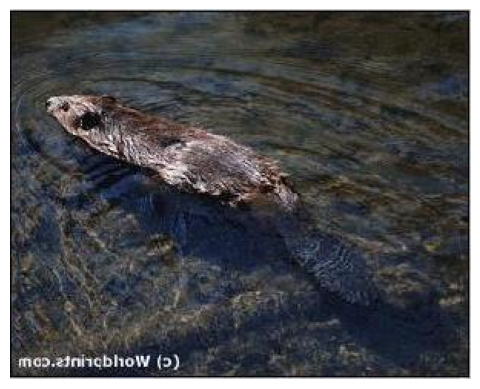

In [28]:
from PIL import Image
path = "..\data/data4/beaver/image_0033.jpg"
img = tf.keras.preprocessing.image.load_img(
    path, target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_vgg.predict(img_array)
print(predictions)
print('Распознанный класс:', np.argmax(predictions))

plt.imshow(Image.open(path))
plt.axis("off")

## БОБР КУРВАААА ЯПЕРДОЛЕ БООООББРРР
0 класс как раз бобер, cnn угадала правильно 

0-bobr

1-llama v tazike

2-panda

Перейдем к InceptionV3

In [29]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))

In [33]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d_2[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

In [34]:
base_model.output

<KerasTensor: shape=(None, 5, 5, 2048) dtype=float32 (created by layer 'mixed10')>

In [36]:
base_model.trainable = False

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs = x)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
5/5 [==============================] - 7s 788ms/step - loss: 155.2554 - accuracy: 0.4154 - val_loss: 108.3245 - val_accuracy: 0.5938
Epoch 2/10
5/5 [==============================] - 3s 561ms/step - loss: 112.0382 - accuracy: 0.3846 - val_loss: 131.3146 - val_accuracy: 0.1562
Epoch 3/10
5/5 [==============================] - 3s 552ms/step - loss: 69.9078 - accuracy: 0.3462 - val_loss: 15.0618 - val_accuracy: 0.5312
Epoch 4/10
5/5 [==============================] - 3s 557ms/step - loss: 22.2363 - accuracy: 0.4077 - val_loss: 3.7348 - val_accuracy: 0.4375
Epoch 5/10
5/5 [==============================] - 3s 566ms/step - loss: 6.6471 - accuracy: 0.3692 - val_loss: 1.3514 - val_accuracy: 0.5938
Epoch 6/10
5/5 [==============================] - 3s 560ms/step - loss: 3.9959 - accuracy: 0.3923 - val_loss: 1.1219 - val_accuracy: 0.6250
Epoch 7/10
5/5 [==============================] - 3s 558ms/step - loss: 1.2531 - accuracy: 0.4385 - val_loss: 1.2386 - val_accuracy: 0.5625
Epoch 8/1

Угадаем ламу в тазике)

In [38]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d_2[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0]

1/1 [==============================] - 1s 872ms/step
[[0.3273797  0.4725791  0.20004116]]
Распознанный класс: 1


(-0.5, 299.5, 242.5, -0.5)

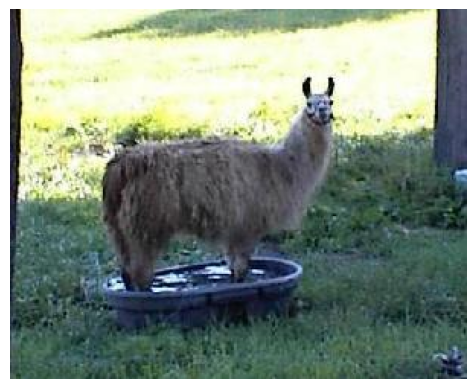

In [41]:
path = "..\data/data4/llama/image_0068.jpg"
img = tf.keras.preprocessing.image.load_img(
    path, target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(predictions)
print('Распознанный класс:', np.argmax(predictions))

plt.imshow(Image.open(path))
plt.axis('off')

И ламу угадало)

1/1 [==============================] - 0s 56ms/step
[[0.0851744  0.35520262 0.55962294]]
Распознанный класс: 2


(-0.5, 240.5, 299.5, -0.5)

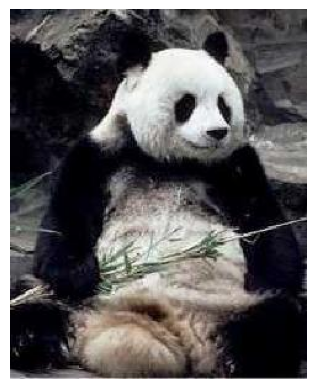

In [43]:
path = "..\data/data4/panda/image_0014.jpg"
img = tf.keras.preprocessing.image.load_img(
    path, target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(predictions)
print('Распознанный класс:', np.argmax(predictions))

plt.imshow(Image.open(path))
plt.axis('off')

Панду угадало правильно)